INSPER - Big Data e Computação em Nuvem

# Big Data e Computação em Nuvem - Projeto Final: Análise de Atraso de Voos

**Integrantes**:

- Flávio Barbosa Shirahige
- Hélio Pereira de Oliveira
- Michel Maurice Conjaud Neto

# 1. Introdução

A aviação é em uma das maiores indústrias da ecomonia global. Apesar do seu potencial de faturamento, há desafios logísticos na alocação de aeronaves que impactam a margem do negócio nessa indústria. Desta forma, o cumprimento da programação de voos acaba se tornando um diferencial para uma empresa.

No entanto, sabemos que há fatores que impactam o cumprimento desta programação e estão além das decisões de uma companhia, como as condições climáticas. Portanto, ter um modelo que preveja se um voo atrasará ou não em determinado aeroporto se torna vital para a obtenção de uma margem significativa. 

O objetivo deste projeto é criar um modelo que preveja se um voo tem potencial para atrasar para que seja possível ter uma melhor acurácia na programação de voos e minimizar as perdas em decorrência da logística. 

# 2. Importando as bibliotecas e dados e criando a sessão do Spark

In [1]:
#Importando as bibliotecas necessárias
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import StringType, FloatType
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, sum, when, stddev, mean, count, isnan
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
from sklearn.metrics import auc, roc_curve
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Criar a sessao do Spark
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_<mudar-nome>") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "5g")\
            .getOrCreate()

In [3]:
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

Abaixo, vamos importar os dados de voos nos EUA de 2012 para não onerar o processamento das informações, dada a limitação de recursos disponíveis.

In [4]:
# Importar os dados de 2012
df = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2012.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, inferSchema=True)

In [5]:
#Visualizar a estrutura dos dados importados
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

Nota-se que dados importados estão no formato adequado para a modelagem. As únicas exceções são CRS_DEP_TIME, DEP_TIME, WHEELS_OFF, WHEELS_ON, CRS_ARR_TIME e ARR_TIME, pois são variáveis que medem o horário (timestamp), mas estão em formato numérico (double). O tratamento destas variáveis será feito na próxima etapa.

# 3. Feature Engineering

Inicialmente vamos excluir a coluna "Unnamed: 27",que não será utilizada por não está no dicionário de dados

In [6]:
# Colocar em cache, pois os códigos de contagem são lentos
df.cache()

DataFrame[FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: double, DEP_TIME: double, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: double, WHEELS_ON: double, TAXI_IN: double, CRS_ARR_TIME: double, ARR_TIME: double, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, Unnamed: 27: string]

In [7]:
#Remover a coluna Unnamed
df = df.drop("Unnamed: 27")
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

In [8]:
# numero de linhas
total_rows = df.count()
print("O total de linhas do dataframe é: ", total_rows)

O total de linhas do dataframe é:  6096762


## 3.2 Definição e Criação da Variável Resposta

Como o objetivo é ter um input para a programação de voos, qualquer informação sobre atraso de voos na decolagem ou na aterrissagem importa. Logo, o atraso será definido a partir da soma das coluna DEP_DELAY (atraso na decolagem) e ARR_DELAY (atraso na aterrissagem), sem tolerência de atraso (DEP_DELAY + ARR_DELAY > 0).

In [9]:
#Criar a variável reposta a partir da soma das colunas ARR_DELAY DEP_DELAY
df = df.withColumn("DELAY", 
                   when(df['ARR_DELAY'] +  df['DEP_DELAY'] > 0, 1)
                   .otherwise(0))

## 3.3 Análise de Variáveis do Dataset

Nessa etapa vamos analisar os missing values.

In [10]:
#Verificando os missing values
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'FL_DATE': 0,
 'OP_CARRIER': 0,
 'OP_CARRIER_FL_NUM': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'CRS_DEP_TIME': 1,
 'DEP_TIME': 75723,
 'DEP_DELAY': 75723,
 'TAXI_OUT': 77977,
 'WHEELS_OFF': 77977,
 'WHEELS_ON': 80894,
 'TAXI_IN': 80894,
 'CRS_ARR_TIME': 2,
 'ARR_TIME': 80894,
 'ARR_DELAY': 91381,
 'CANCELLED': 0,
 'CANCELLATION_CODE': 6017900,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 1,
 'ACTUAL_ELAPSED_TIME': 91381,
 'AIR_TIME': 91381,
 'DISTANCE': 0,
 'CARRIER_DELAY': 5081604,
 'WEATHER_DELAY': 5081604,
 'NAS_DELAY': 5081604,
 'SECURITY_DELAY': 5081604,
 'LATE_AIRCRAFT_DELAY': 5081604,
 'DELAY': 0}

As variáveis de atraso (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) têm um valor de missing values elevado. Vamos analisar a distribuição destes dados.

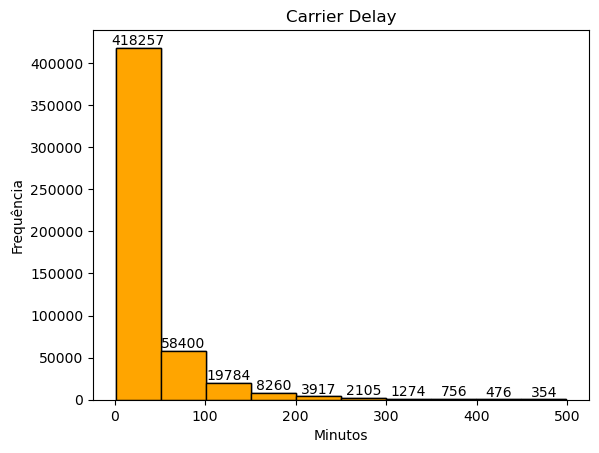

In [11]:
# Filter rows where CARRIER_DELAY > 0
carrier_delay_df = df.filter((col("CARRIER_DELAY") > 0) & (col("CARRIER_DELAY") < 500))

df_carrier_delay = carrier_delay_df.select('CARRIER_DELAY').toPandas()

# Cria um dataframe com os dados da coluna CARRIER_DELAY
plt.hist(df_carrier_delay['CARRIER_DELAY'], bins=10, edgecolor='black')
counts, bins, _ = plt.hist(df_carrier_delay['CARRIER_DELAY'], bins=10, edgecolor='black', color='orange')
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.title('Carrier Delay')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

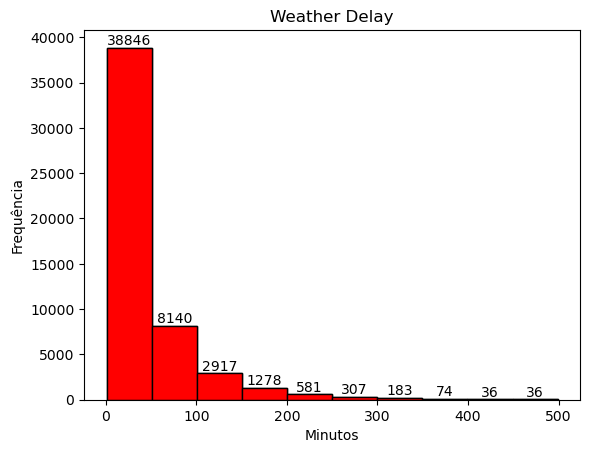

In [12]:
# Filter rows where WEATHER_DELAY > 0
weather_delay_df = df.filter((col("WEATHER_DELAY") > 0) & (col("WEATHER_DELAY") < 500))

df_weather_delay = weather_delay_df.select('WEATHER_DELAY').toPandas()

# Cria um dataframe com os dados da coluna WEATHER_DELAY
plt.hist(df_weather_delay['WEATHER_DELAY'], bins=10, edgecolor='black')
counts, bins, _ = plt.hist(df_weather_delay['WEATHER_DELAY'], bins=10, edgecolor='black', color='red')
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.title('Weather Delay')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

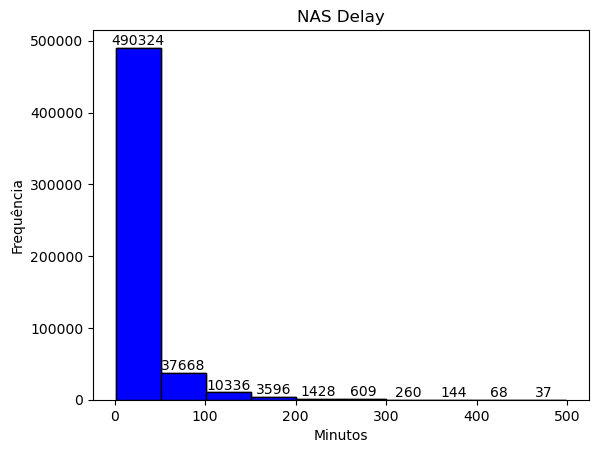

In [13]:
# Filter rows where NAS_DELAY > 0
nas_delay_df = df.filter((col("NAS_DELAY") > 0) & (col("NAS_DELAY") < 500))

df_nas_delay = nas_delay_df.select('NAS_DELAY').toPandas()

# Cria um dataframe com os dados da coluna NAS_DELAY
plt.hist(df_nas_delay['NAS_DELAY'], bins=10, edgecolor='black')
counts, bins, _ = plt.hist(df_nas_delay['NAS_DELAY'], bins=10, edgecolor='black', color = 'blue')
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.title('NAS Delay')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

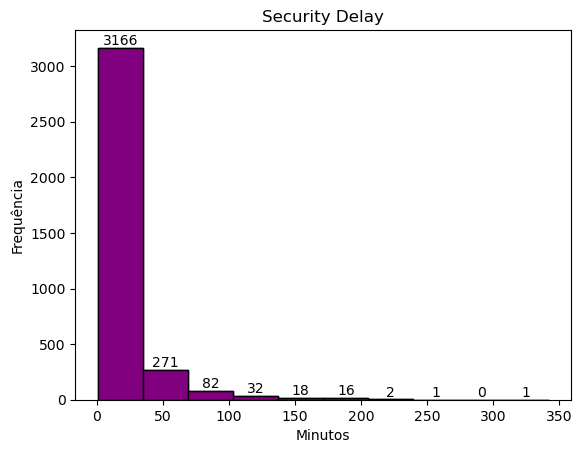

In [14]:
# Filter rows where SECURITY_DELAY > 0
security_delay_df = df.filter((col("SECURITY_DELAY") > 0) & (col("SECURITY_DELAY") < 500))

df_security_delay = security_delay_df.select('SECURITY_DELAY').toPandas()

# Cria um dataframe com os dados da coluna security_DELAY
plt.hist(df_security_delay['SECURITY_DELAY'], bins=10, edgecolor='black')
counts, bins, _ = plt.hist(df_security_delay['SECURITY_DELAY'], bins=10, edgecolor='black', color = 'purple')
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.title('Security Delay')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

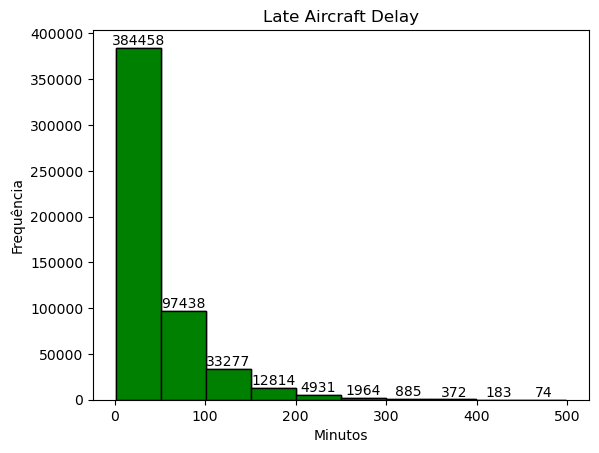

In [15]:
# Filter rows where LATE_AIRCRAFT_DELAY > 0
LAD_delay_df = df.filter((col("LATE_AIRCRAFT_DELAY") > 0) & (col("LATE_AIRCRAFT_DELAY") < 500))

df_late_delay = LAD_delay_df.select('LATE_AIRCRAFT_DELAY').toPandas()

# Cria um dataframe com os dados da coluna security_DELAY
plt.hist(df_late_delay['LATE_AIRCRAFT_DELAY'], bins=10, edgecolor='black')
counts, bins, _ = plt.hist(df_late_delay['LATE_AIRCRAFT_DELAY'], bins=10, edgecolor='black', color = 'green')
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.title('Late Aircraft Delay')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

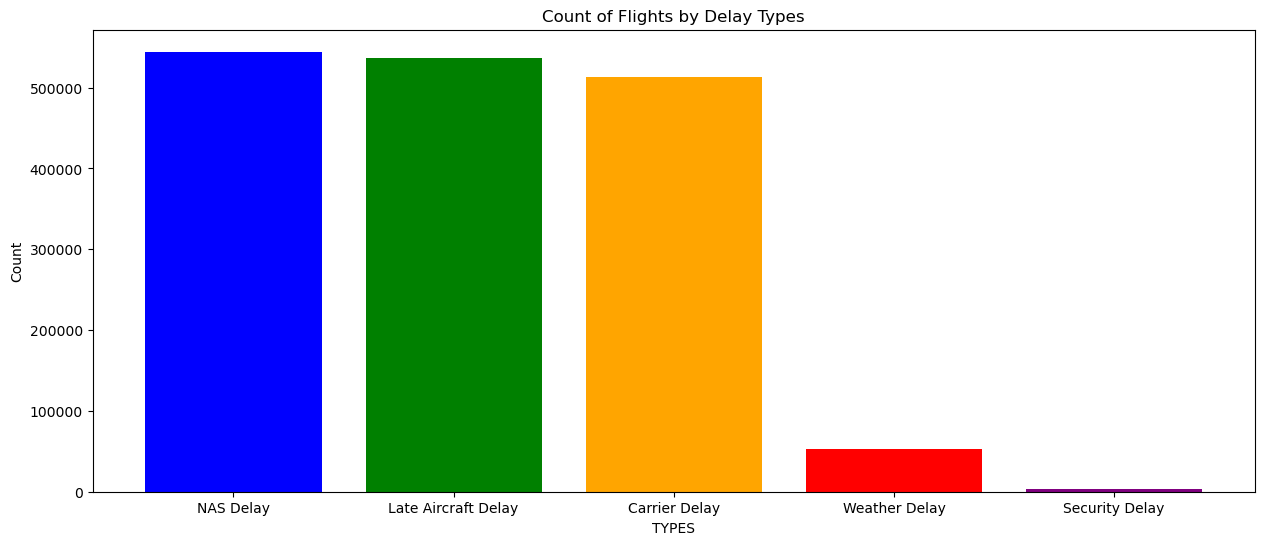

In [16]:
# Filter rows for each delay type
carrier_delay_df = df.filter((col("CARRIER_DELAY") > 0) & (col("CARRIER_DELAY") < 500))
weather_delay_df = df.filter((col("WEATHER_DELAY") > 0) & (col("WEATHER_DELAY") < 500))
nas_delay_df = df.filter((col("NAS_DELAY") > 0) & (col("NAS_DELAY") < 500))
security_delay_df = df.filter((col("SECURITY_DELAY") > 0) & (col("SECURITY_DELAY") < 500))
late_aircraft_delay_df = df.filter((col("LATE_AIRCRAFT_DELAY") > 0) & (col("LATE_AIRCRAFT_DELAY") < 500))

# Count occurrences for each delay type
count_carrier_delay = carrier_delay_df.count()
count_weather_delay = weather_delay_df.count()
count_nas_delay = nas_delay_df.count()
count_security_delay = security_delay_df.count()
count_late_delay = late_aircraft_delay_df.count()

# Create a list of tuples (label, count)
data_tuples = [('Carrier Delay', count_carrier_delay),
               ('Weather Delay', count_weather_delay),
               ('NAS Delay', count_nas_delay),
               ('Security Delay', count_security_delay),
               ('Late Aircraft Delay', count_late_delay)]

# Sort the list by counts in descending order
sorted_data = sorted(data_tuples, key=lambda x: x[1], reverse=True)

# Unpack the sorted data
labels, counts = zip(*sorted_data)



# Plot bar chart
plt.figure(figsize=(15, 6))
plt.bar(labels, counts, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Count of Flights by Delay Types')
plt.xlabel('TYPES')
plt.ylabel('Count')

plt.show()

In [17]:
df.select('CANCELLATION_CODE').describe().toPandas()

,summary,CANCELLATION_CODE
0,count,78862
1,mean,None
2,stddev,None
3,min,A
4,max,D


Os missing values das colunas CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY possivelmente são zero minutos de atraso. Logo, vamos preencher os missing values dessas colunas com ZERO. No entanto, verifica-se que há valores muito altos de atraso. Como algumas normas internacionais estabelacem que um voo cima de 3 horas de atraso pode ser cancelado pela companhia aérea, vamos excluir essas informações do dataset.

No mais, verificamos que a coluna CANCELLATION_CODE possui um número extremamente elevado de missing values. Logo, vamos excluí-la.

## 3.4 Criação de novas colunas

Serão criadas novas colunas que a serão utilizadas na etapa de modelagem, a saber:

 - MONTH: coluna com o mês do voo a partir da coluna (FL_DATE);
 - GENERAL_DELAY: informação se o voo tem um atraso acima de 180 minutos em qualquer um dos quesitos (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, VLATE_AIRCRAFT_DELAY);
 - DEP_PERIOD: é uma variável com o período que o voo saiu (manha, tarde, noite, madrugada);
 - ARR_PERIOD: é uma variável com o período que o voo chegou (manha, tarde, noite, madrugada);
 - DISTANCE_TYPE: é coluna com o tipo de distância entre os aeroportos dos voos (perto, médio e distante).

In [18]:
# Criar uma variável com o mês do voo
df = df.withColumn('FL_MONTH', f.month(df.FL_DATE))

In [19]:
# Criando filtro dos Outliers com atraso > 180 minutos (Critério Internacional)
df = df.withColumn("GENERAL_DELAY", 
                   when((df['CARRIER_DELAY'] > 180) | (df['WEATHER_DELAY'] > 180) | (df['NAS_DELAY'] > 180) | (df['SECURITY_DELAY'] > 180) |
                        (df['LATE_AIRCRAFT_DELAY'] > 180) ,1)
                   .otherwise(0))

In [20]:
# Criar uma variável o período que o voo saiu (manha, tarde, noite, madrugada)
df = df.withColumn("DEP_PERIOD", 
                   when((df['DEP_TIME'] >= 0) & (df['DEP_TIME'] < 600), "Madrugada")
                   .when((df['DEP_TIME'] >= 600) & (df['DEP_TIME'] < 1200), "Manha")
                   .when((df['DEP_TIME'] >= 1200) & (df['DEP_TIME'] < 1800), "Tarde")
                   .when((df['DEP_TIME'] >= 1800) & (df['DEP_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

Analisando a quantidade de voos por período de Saída

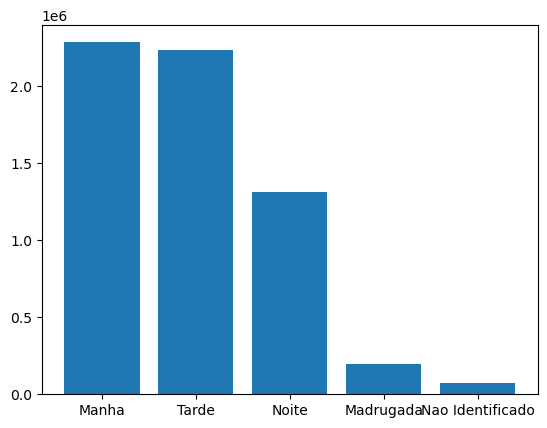

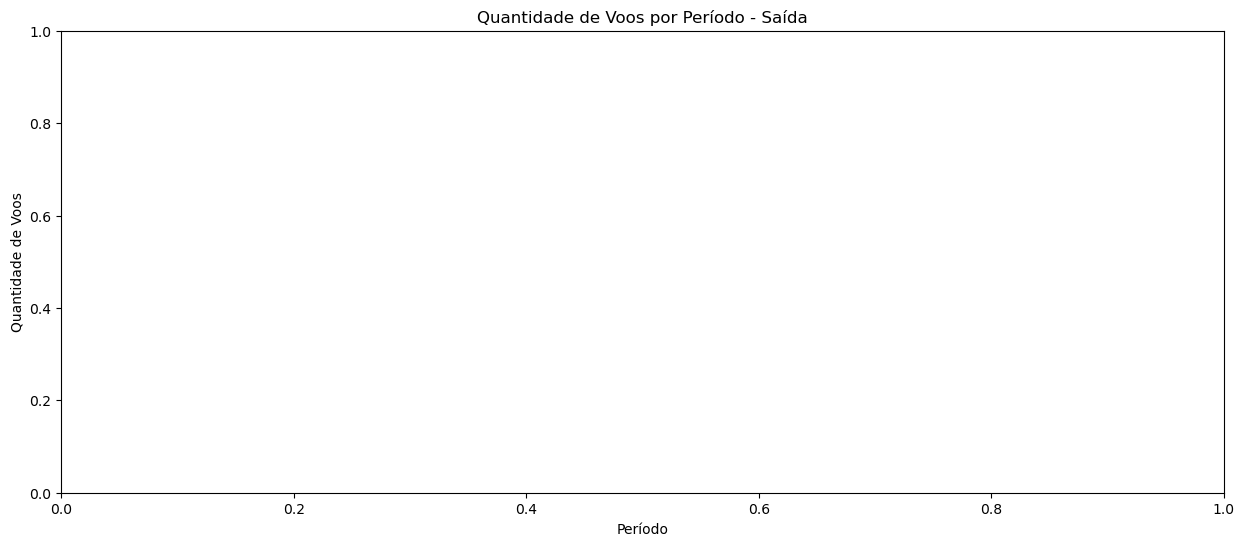

In [21]:
# Cria um dataframe com os dados da coluna DEP_PERIOD 
df_arr_period = df.select(df['DEP_PERIOD']).toPandas()

arr_period_counts = df_arr_period['DEP_PERIOD'].value_counts()
plt.bar(arr_period_counts.index, arr_period_counts.values)

# Adicionando rótulos e título
plt.figure(figsize=(15, 6))
plt.title('Quantidade de Voos por Período - Saída')
plt.xlabel('Período')
plt.ylabel('Quantidade de Voos')
plt.show()

In [22]:
# Criar uma variável o período que o voo chegou (manha, tarde, noite, madrugada)
df = df.withColumn("ARR_PERIOD", 
                   when((df['ARR_TIME'] >= 0) & (df['ARR_TIME'] < 600), "Madrugada")
                   .when((df['ARR_TIME'] >= 600) & (df['ARR_TIME'] < 1200), "Manha")
                   .when((df['ARR_TIME'] >= 1200) & (df['ARR_TIME'] < 1800), "Tarde")
                   .when((df['ARR_TIME'] >= 1800) & (df['ARR_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

Analisando a quantidade de voos por período de Chegada

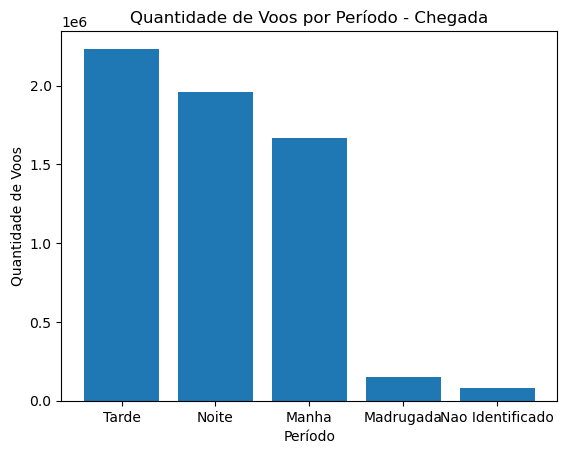

In [23]:
# Cria um dataframe com os dados da coluna ARR_PERIOD 
df_arr_period = df.select(df['ARR_PERIOD']).toPandas()

arr_period_counts = df_arr_period['ARR_PERIOD'].value_counts()
plt.bar(arr_period_counts.index, arr_period_counts.values)

# Adicionando rótulos e título
plt.title('Quantidade de Voos por Período - Chegada')
plt.xlabel('Período')
plt.ylabel('Quantidade de Voos')
plt.show()

Para criar a coluna DISTANCE_TYPE, vamos plotar um histograma para verificar a distribuição e criar um critério que não desbalancei muito os dados.

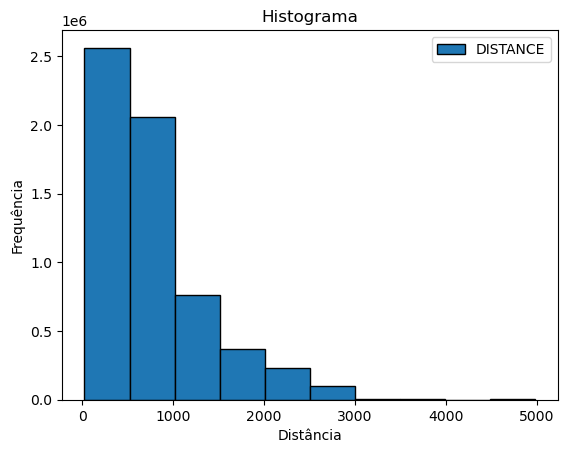

In [24]:
# Cria um dataframe com os dados da coluna DISTANCE
df_distance = df.select(df['DISTANCE']).toPandas()

# Plota histograma das distâncias com 10 bins para verificar a distribuição dos voos
df_distance.plot.hist(bins=10, edgecolor='black')
plt.title('Histograma')
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.show()

A partir do histograma acima, vamos definir o seguinte critério para classificar as distâncias:

- próximo: abaixo de 500 milhas
- médio: entre 500 e 1000 milhas
- distante: acima de 1000 milhas

In [25]:
#Criar coluna "Tipo de Distância" com o critério acima
df = df.withColumn("DISTANCE_TYPE", 
                   when(df['DISTANCE'] > 1000, "distant")
                   .when(df['DISTANCE'] > 500, "medium")
                   .otherwise("near"))

## 3.5 Tratamento final dos dados: exclusão de linhas e dolunas do dataset e preenchendo os missing values

Primeiramente, vamos filtrar os voos cancelados, uma vez que não há atraso em relação a eles.

In [26]:
df = df.filter(df['CANCELLED'] == 0)

Em seguida, vamos filtrar os voos cujo atraso é maior do que 3 horas, conforme definido na coluna GENERAL_DELAY (valores nessa coluna igual a ZERO).

In [27]:
df = df.filter(df['GENERAL_DELAY'] == 0)

A próxima etapa é excluir as linhas com missing values das colunas 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', pois representam menos de 1%.

In [28]:
#tratar os missing values (inicialmente coloquei para excluir todas as linhas que tem missing values, pois representam menos de 1% )
df = df.na.drop(subset=['AIR_TIME', 'ACTUAL_ELAPSED_TIME'])

Agora, vamos remover as colunas que não serão utilizadas:

 - FL_DATE: coluna de data. Será excluída, pois vamos usar a coluna MONTH para verificar alguma sazonalidade
 - OP_CARRIER_FL_NUM: ID do voo;
 - CRS_DEP_TIME, DEP_TIME, DEP_DELAY, WHEELS_OFF, ARR_TIME, ARR_DELAY, WHEELS_ON e CRS_ARR_TIME: informação do horário planejado do voo. Esta informação já está em DELAY;
 - CANCELLED: foram filtrados os valores, restando apenas ZERO nessa coluna;
 - CANCELLATION_CODE: não possui valores;
 - GENERAL_DELAY: há apenas 1 valor (0).

In [29]:
#Removendo colunas que não serão utilizadas
df = df.drop('FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON',
                   'CRS_ARR_TIME', 'ARR_TIME', 'OP_CARRIER_FL_NUM', 'ARR_DELAY', 
                  'DEP_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'GENERAL_DELAY')

Por fim, vamos preencher os missing values das colunas abaixo com ZERO:

- CARRIER_DELAY
- WEATHER_DELAY
- NAS_DELAY
- SECURITY_DELAY
- LATE_AIRCRAFT_DELAY

In [30]:
df = df.na.fill(0, subset=["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"])

Abaixo, vamos confirmar se todos os missign values foram tratados.

In [31]:
#Verificando se as linhas com missing values foram excluiídas
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

Por último, vamos confirmar se não há valores negativos atípicos.

In [32]:
# Verificar se há valores negativos
def conta_negativo(coluna):
    try: 
        return df.filter((df[coluna]<0)).count()
    except:
        return "Variável não numérica"

{col:conta_negativo(col) for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

# 4. Analise Gráfica do Dataset

Primeiramente, vamos ver os voos atrasados ao longo do meses de 2012:

# Gráfico de atrasos vs. total de voos ao longo dos meses

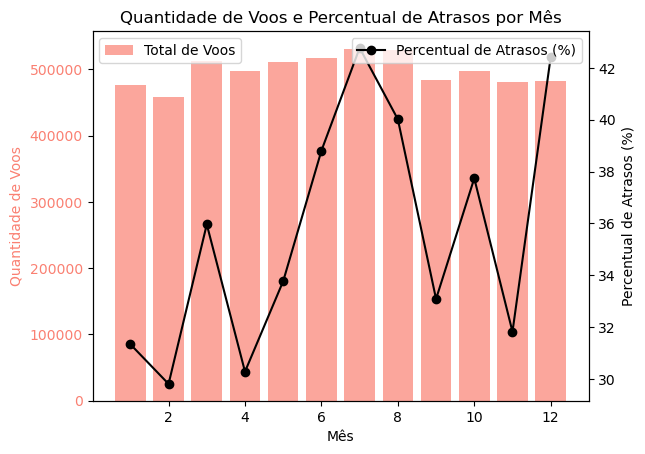

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df_delay = df[['FL_MONTH', 'DELAY']].toPandas()

# Calcular o total de voos (DELAY 0 e 1) por mês
total_voos_por_mes = df_delay.groupby('FL_MONTH')['DELAY'].count()

# Calcular o número de voos atrasados (DELAY 1) por mês
voos_atrasados_por_mes = df_delay[df_delay['DELAY'] == 1].groupby('FL_MONTH')['DELAY'].count()

# Calcular o percentual de atrasos por mês
percentual_atrasos_por_mes = (voos_atrasados_por_mes / total_voos_por_mes) * 100

# Criar a figura e os eixos
fig, ax1 = plt.subplots()

# Gráfico de barras para o número total de voos por mês
ax1.bar(total_voos_por_mes.index, total_voos_por_mes.values, color='salmon', label='Total de Voos', alpha=0.7)
ax1.set_xlabel('Mês')
ax1.set_ylabel('Quantidade de Voos', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')

# Segundo eixo y para o percentual de atrasos por mês
ax2 = ax1.twinx()
ax2.plot(percentual_atrasos_por_mes.index, percentual_atrasos_por_mes.values, color='black', marker='o', label='Percentual de Atrasos (%)')
ax2.set_ylabel('Percentual de Atrasos (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adicionar legenda
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Título do gráfico
plt.title('Quantidade de Voos e Percentual de Atrasos por Mês')

# Exibir o gráfico
plt.show()


Há um pico de atrasos de voos no verão.

# ORIGIN aeroportos com maior percentual de atrasos

Tratando a base para geração dos gráficos

In [34]:

#Total de voos por ORIGIN
flights_by_origin = df.groupBy("ORIGIN").count()
#Total de voos atrasados por ORIGIN
delayed_flights_by_origin = df.filter((df['DELAY']==1)).groupBy("ORIGIN").count()
# Alias the count columns to avoid naming conflicts
flights_by_origin = flights_by_origin.withColumnRenamed("count", "total_count")
delayed_flights_by_origin = delayed_flights_by_origin.withColumnRenamed("count", "delayed_count")
#Realizando um filtro para contar apenas os aeroporto que possuem mais que 1000 voos em atraso
delayed_flights_by_origin = delayed_flights_by_origin.filter(delayed_flights_by_origin["delayed_count"] > 1000)
#Relação entre Voos atrasado e Voos no tempo por ORIGIN
# Join the DataFrames to get the total and delayed flights in the same DataFrame
flights_relation_by_origin = flights_by_origin.join(delayed_flights_by_origin, 
                                                          "ORIGIN", "left_outer")
#Nome das colunas do DF flights_relation_by_origin ['ORIGIN','total_count','delayed_count','Percentage_Delayed']
# Calculate the percentage of delayed flights
flights_relation_by_origin = flights_relation_by_origin.withColumn("Percentage_Delayed", 
                                                                   (flights_relation_by_origin["delayed_count"] 
                                                                    / flights_relation_by_origin["total_count"]) * 100)

flights_relation_by_origin = flights_relation_by_origin.toPandas()

# DF para gráfico de percentual de atraso por origin
delay_sorted = flights_relation_by_origin.sort_values('Percentage_Delayed', ascending=False)
top_20_delayed = delay_sorted.head(20)

# DF para gráfico de qtd de voos por origin 
total_sorted = flights_relation_by_origin.sort_values('total_count', ascending=False)
top_20_total = total_sorted.head(20)

Gráfico com o TOP 20 aeroportos por percentual de atraso

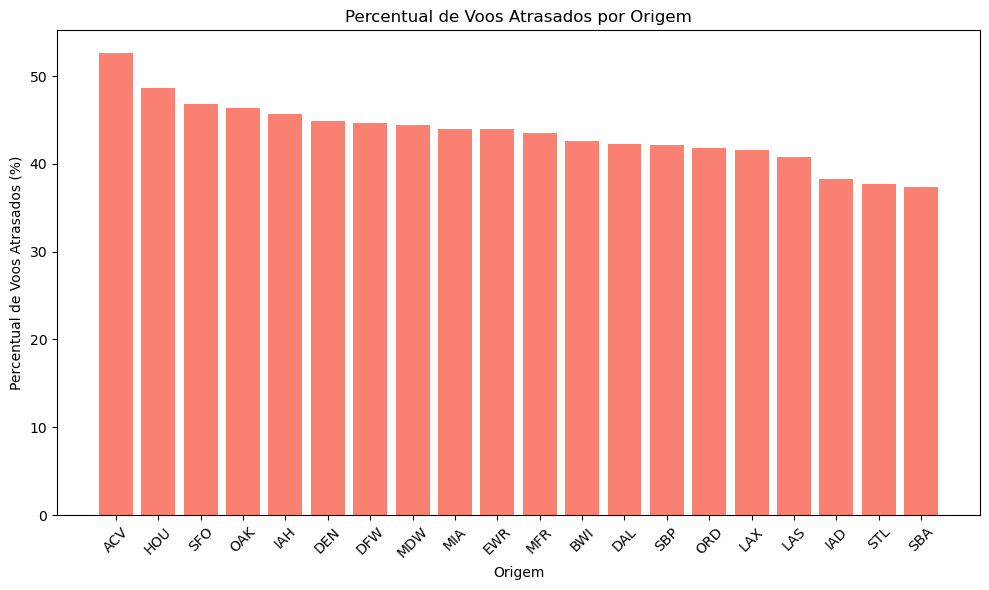

In [35]:
data = top_20_delayed

# Criando o gráfico de barras para Percentage_Delayed por Origin
plt.figure(figsize=(10, 6))
plt.bar(data['ORIGIN'], data['Percentage_Delayed'], color='salmon')
plt.title('Percentual de Voos Atrasados por Origem')
plt.xlabel('Origem')
plt.ylabel('Percentual de Voos Atrasados (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Gráfico com o TOP 20 aeroportos por quantidade de voos

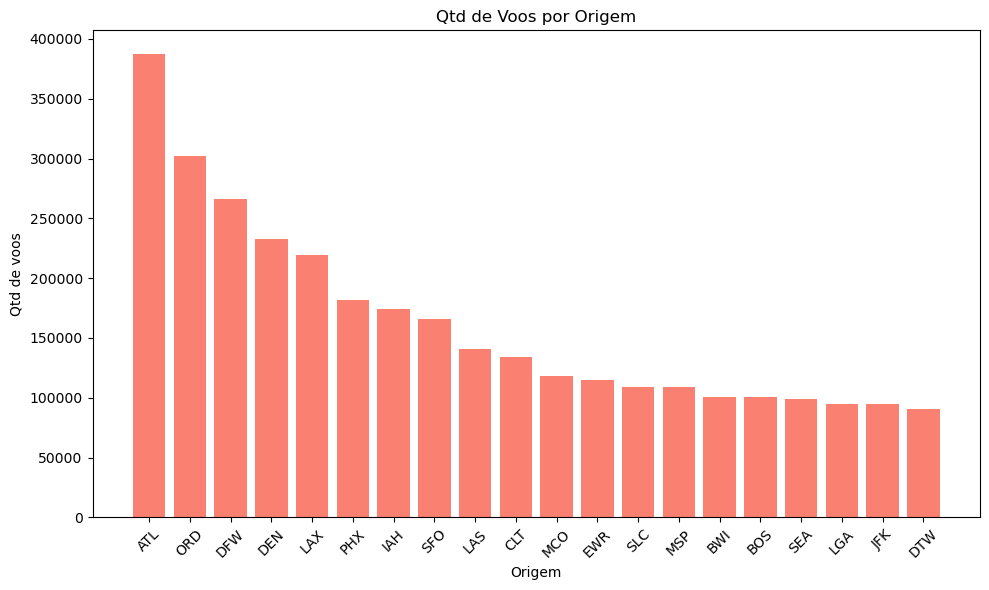

In [36]:
data = top_20_total

# Criando o gráfico de barras para total_count por Origin
plt.figure(figsize=(10, 6))
plt.bar(data['ORIGIN'], data['total_count'], color='salmon')
plt.title('Qtd de Voos por Origem')
plt.xlabel('Origem')
plt.ylabel('Qtd de voos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DEST aeroportos com maior numero de atrasos (em %)

Tratando a base para geração dos gráficos

In [37]:
#Total de voos por DEST
flights_by_dest = df.groupBy("DEST").count()
#Total de voos atrasados por ORIGIN
delayed_flights_by_dest = df.filter((df['DELAY']==1)).groupBy("DEST").count()
# Alias the count columns to avoid naming conflicts
flights_by_dest = flights_by_dest.withColumnRenamed("count", "total_count")
delayed_flights_by_dest = delayed_flights_by_dest.withColumnRenamed("count", "delayed_count")
#Realizando um filtro para contar apenas os aeroporto que possuem mais que 1000 voos em atraso
delayed_flights_by_dest = delayed_flights_by_dest.filter(delayed_flights_by_dest["delayed_count"] > 1000)
#Relação entre Voos atrasado e Voos no tempo por ORIGIN
# Join the DataFrames to get the total and delayed flights in the same DataFrame
flights_relation_by_dest = flights_by_dest.join(delayed_flights_by_dest, 
                                                          "DEST", "left_outer")
# Calculate the percentage of delayed flights
flights_relation_by_dest = flights_relation_by_dest.withColumn("Percentage_Delayed", 
                                                                   (flights_relation_by_dest["delayed_count"] 
                                                                    / flights_relation_by_dest["total_count"]) * 100)


flights_relation_by_dest = flights_relation_by_dest.toPandas()

# DF para gráfico de percentual de atraso por origin
delay_sorted = flights_relation_by_dest.sort_values('Percentage_Delayed', ascending=False)
top_20_delayed = delay_sorted.head(20)

# DF para gráfico de qtd de voos por origin 
total_sorted = flights_relation_by_dest.sort_values('total_count', ascending=False)
top_20_total = total_sorted.head(20)



Gráfico com o TOP 20 aeroportos por percentual de atraso

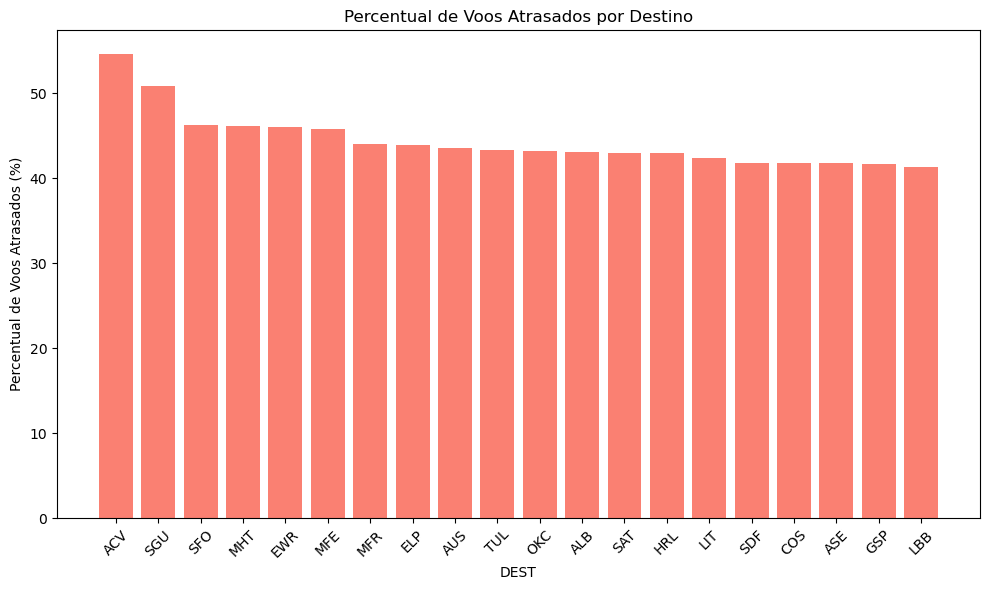

In [38]:
data = top_20_delayed

# Criando o gráfico de barras para Percentage_Delayed por DES
plt.figure(figsize=(10, 6))
plt.bar(data['DEST'], data['Percentage_Delayed'], color='salmon')
plt.title('Percentual de Voos Atrasados por Destino')
plt.xlabel('DEST')
plt.ylabel('Percentual de Voos Atrasados (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Gráfico com o TOP 20 aeroportos por quantidade de voos

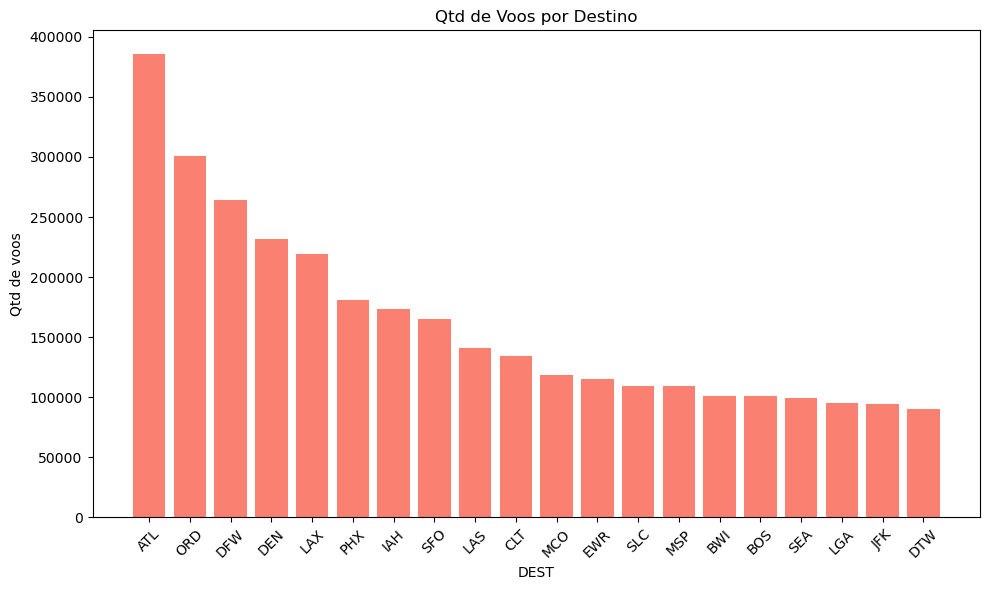

In [39]:
data = top_20_total

# Criando o gráfico de barras para total_count por Dest
plt.figure(figsize=(10, 6))
plt.bar(data['DEST'], data['total_count'], color='salmon')
plt.title('Qtd de Voos por Destino')
plt.xlabel('DEST')
plt.ylabel('Qtd de voos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico dois eixos % por aeroporto vs total de voos por aeroporto

In [40]:
# Calcule a porcentagem de voos com atraso para cada aeroporto
total_voos = df.groupBy("ORIGIN", "DEST").count()
voos_com_atraso = df.filter(df["DELAY"]==1).groupBy("ORIGIN").count()
# Order the DataFrame by count in descending order
total_voos = total_voos.orderBy("count", ascending=False)
# Sum the counts of the top 20 origin-destination pairs
sum_top_20_counts = total_voos.limit(20).agg({"count": "sum"})

In [41]:
total_voos.show()

+------+----+-----+
|ORIGIN|DEST|count|
+------+----+-----+
|   SFO| LAX|17044|
|   LAX| SFO|16701|
|   OGG| HNL|12723|
|   HNL| OGG|12675|
|   JFK| LAX|11609|
|   LAX| JFK|11562|
|   LAX| LAS|10928|
|   LAS| LAX|10627|
|   ATL| LGA|10523|
|   LGA| ATL|10518|
|   LAX| SAN| 9938|
|   SAN| LAX| 9905|
|   PHX| LAX| 9753|
|   LAX| PHX| 9747|
|   ATL| MCO| 9031|
|   MCO| ATL| 8977|
|   LGA| ORD| 8916|
|   ORD| LGA| 8774|
|   HNL| LIH| 8694|
|   LIH| HNL| 8611|
+------+----+-----+
only showing top 20 rows



In [42]:
df_test = df.filter((df['DELAY']==1)).count()
print(df_test)

2137815


In [43]:
df_test = df.filter((df['DELAY']==1)).count()
print(df_test)

2137815


In [44]:
sum_top_20_counts.show()

+----------+
|sum(count)|
+----------+
|    217256|
+----------+



## Matriz de Correlação

Vamos plotar a matriz de correlação para verificar a colinearidade entre as variáveis numéricas.

In [45]:
# verificar quais são as colunas numéricas
colunas_numericas = [coluna for coluna, tipo in df.dtypes if tipo in ['int', 'double']]
# Selecionar apenas colunas numéricas
df_numericas = df.select(*colunas_numericas)

<AxesSubplot: >

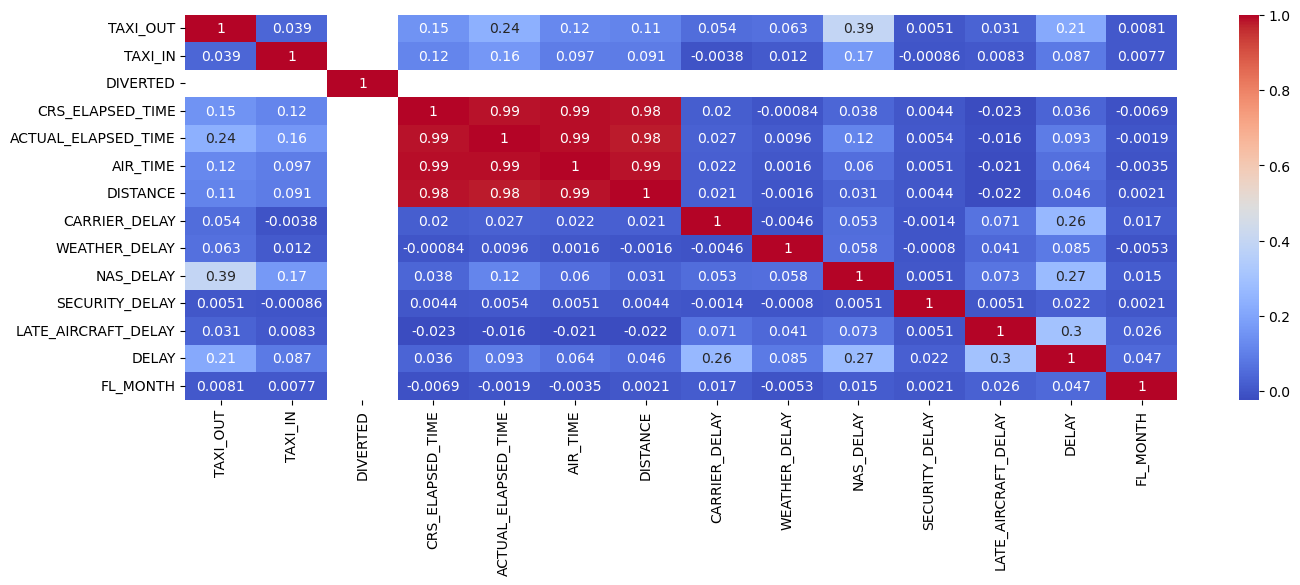

In [46]:
# converter para um coluna vetor 
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_numericas.columns, outputCol=vector_col)
df_vector = assembler.transform(df_numericas).select(vector_col)

# Obter a matriz de correlação
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()
corr_matrix = matrix.tolist() 

# Colocar as correlações das variáveis num dataframe em pandas
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_numericas.columns, index=df_numericas.columns)

# Plotar a matriz
plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="coolwarm", annot=True)

Há um correlação maior entre as variáveis de tempo decorrido do voo, tempo total e distância. É algo esperado, pois quanto maior a distância, maior o tempo de voo.

# 5. Modelagem

Para essa etapa de modelagem, vamos estimar os modelos abaixo e verificar qual é que possui o melhor desempenho para estimar se o voo atrasará ou não.

- Regressão Logística (sem penalização e regularização);
- Floresta Aleatória (com 50 árvores e número máximo de divisões de 5);
- Floresta Aleatória Ótima, onde serão estimados os melhores hiperparâmetros de árvore e divisão).

## 5.1 Separação entre Treino e Teste

A primeira etapa da modelagem é separar o dataset entre treino e teste e criar um dataset específicio para encontrar os hiperparâmetros ótimos do modelo de floresta aleatória.

In [47]:
# criar df de treino e teste
train_df, test_df = df.randomSplit( [0.8, 0.2], seed=42)

In [48]:
# criar df para tunar os hiperparametros
toy_df = test_df.sample(False, 0.01, seed=42)

In [49]:
print("O dataset de treino tem: ", train_df.count())
print("O dataset de teste tem: ", test_df.count())
print("O dataset de ajuste de hiperparâmetros tem: ", toy_df.count())

O dataset de treino tem:  4779318
O dataset de teste tem:  1195976
O dataset de ajuste de hiperparâmetros tem:  12055


## 5.2 Tratamento das Variáveis Categóricas: One Hot Encoding

Abaixo vamos criar o vetor para o pipeline que irá converter as variáveis catégorias pelo one hot encoding.

In [50]:
#Preparar para converter as colunas categóricas pelo one hot encoding (coloque o FL_MONTH como categórica)
cat_features = ['OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_PERIOD', 'ARR_PERIOD', 'DISTANCE_TYPE', 'FL_MONTH']

indexOutputCols = [x + 'Index' for x in cat_features]
oheOutputCols = [x + 'OHE' for x in cat_features]
stringIndexer = StringIndexer(inputCols=cat_features,
                             outputCols=indexOutputCols,
                             handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

## 5.3 Tratamento das Variáveis Numéricas: Normalização

E emseguida vamos criar o vetor para o pipeline que normalizar as variáveis numéricas.

In [51]:
#Preparar para converter as colunas númericas
num_features = ['TAXI_OUT', 'TAXI_IN', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
                'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

numVecAssembler = VectorAssembler(inputCols = num_features, outputCol = 'features')

stadScaler = StandardScaler(inputCol = 'features', outputCol = 'features_scaled')

## 5.4 Juntando os Vetores de One Hot Encoding e Normalização

O próximo passo é unir os valores acima.

In [52]:
assemblerInputs = oheOutputCols + ['features_scaled']

VecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features_vector')

In [53]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stadScaler, VecAssembler]

## 5.5 Criação e Aplicação do Pipeline de Transformação do Dados

Abaixo será criado e aplicado o pipeline de transformação do dado a partir dos vetores acima.

In [54]:
# Criacao do pipeline de transformacao
transform_pipeline = Pipeline(stages=stages)

#aplicacao do pipeline nos dados treino - ajuste da transformacao
fitted_transformer = transform_pipeline.fit(train_df)

#aplicacao da transformacao nos dados de treino
transformed_train_df = fitted_transformer.transform(train_df)

transformed_train_df.limit(5).toPandas()

,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,TAXI_IN,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,...,OP_CARRIEROHE,ORIGINOHE,DESTOHE,DEP_PERIODOHE,ARR_PERIODOHE,DISTANCE_TYPEOHE,FL_MONTHOHE,features,features_scaled,features_vector
0,AA,ABQ,DFW,5.0,3.0,0.0,100.0,81.0,73.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 3.0, 0.0, 100.0, 81.0, 73.0, 569.0, 0.0,...","(0.5993661005164417, 0.6374333053965965, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,AA,ABQ,DFW,5.0,10.0,0.0,100.0,87.0,72.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 10.0, 0.0, 100.0, 87.0, 72.0, 569.0, 0.0...","(0.5993661005164417, 2.1247776846553217, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,AA,ABQ,DFW,6.0,4.0,0.0,105.0,82.0,72.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 4.0, 0.0, 105.0, 82.0, 72.0, 569.0, 0.0,...","(0.71923932061973, 0.8499110738621286, 0.0, 1....","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,AA,ABQ,DFW,6.0,5.0,0.0,100.0,85.0,74.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 5.0, 0.0, 100.0, 85.0, 74.0, 569.0, 0.0,...","(0.71923932061973, 1.0623888423276608, 0.0, 1....","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,AA,ABQ,DFW,6.0,6.0,0.0,100.0,95.0,83.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 0.0, 100.0, 95.0, 83.0, 569.0, 0.0,...","[0.71923932061973, 1.274866610793193, 0.0, 1.3...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


## 5.2 Regressão Logísitica

O primeiro modelo a ser estimado é o de regressão logística. Vamos treinar o modelo, aplicá-lo no dataset de teste e verificar o seu desempenho.

### 5.2.1 Treinamento do Modelo

In [55]:
log_reg = LogisticRegression(featuresCol='features_vector', labelCol='DELAY') 

pipe_stages_log_reg = stages + [log_reg]
pipe_log_reg  = Pipeline(stages=pipe_stages_log_reg )

In [56]:
fitted_pipe_log_reg = pipe_log_reg.fit(train_df)

In [57]:
pred_log_reg = fitted_pipe_log_reg.transform(test_df)

### 5.2.2 Avaliação do Modelo

In [58]:
# Crie um avaliador de classificação multiclasse
evaluator = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_log = evaluator.evaluate(pred_log_reg)
print(f"Acurácia da Regressão Logística: {accuracy_log}")

# Matriz de confusão
y_true_log = pred_log_reg.select(['DELAY']).collect()
y_pred_log = pred_log_reg.select(['prediction']).collect()

print(classification_report(y_true_log, y_pred_log))

Acurácia da Regressão Logística: 0.8264271189388416
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    767186
           1       0.91      0.57      0.70    428790

    accuracy                           0.83   1195976
   macro avg       0.86      0.77      0.79   1195976
weighted avg       0.84      0.83      0.81   1195976



Pela análise do indicadores de desempenho acima, o modelo:

- Acertou 83% do status do total dos voos;
- Acertou 91% dos voos atrasados (classificacao correta de atraso);
- Acertou 80% dos voos que saíram no horário (classificacao correta de voos no horário);
- Do total de voos que saíram no horário, estimou corretamente 97%
- Do total de voos que atrasaram, estimou corretamente 57%

In [59]:
# calcula a curva ROC e a área sob ela
pred_log_reg_pd = pred_log_reg.select('DELAY', 'prediction', 'probability').toPandas()
pred_log_reg_pd['probability'] = pred_log_reg_pd['probability'].map(lambda x: list(x))
pred_log_reg_pd['encoded_DELAY'] = pred_log_reg_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])
y_pred_log_reg = np.array(pred_log_reg_pd['probability'].tolist())
y_true_log_reg = np.array(pred_log_reg_pd['encoded_DELAY'].tolist())
fpr_log, tpr_log, threshold = roc_curve(y_score=y_pred_log_reg[:,0], y_true=y_true_log_reg[:,0])
auc_log = auc(fpr_log, tpr_log)

print('AUC Regressão Logística: {:.3f}'.format(auc_log))

AUC Regressão Logística: 0.857


/tmp/ipykernel_9954/3090056430.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


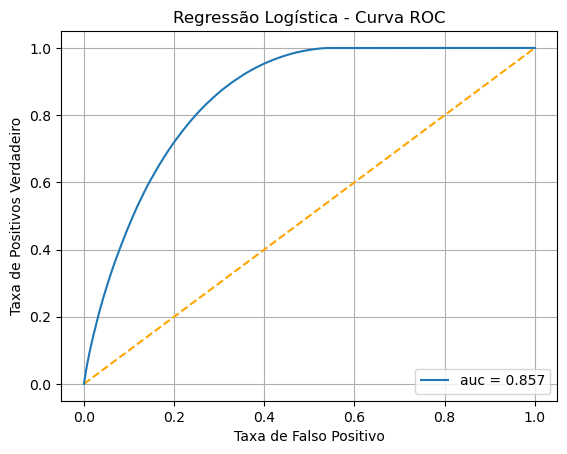

In [60]:
#plota a curva ROC
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_log, tpr_log, label='auc = {:.3f}'.format(auc_log))
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Regressão Logística - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.3 Floresta Aleatória

O próximo modelo a ser estimado é o de Floresta Aleatória (com 50 árvores e número máximo de divisões de 5). Vamos treinar o modelo, aplicá-lo no dataset de teste e verificar o seu desempenho.

### 5.3.1 Treinamento do Modelo - 50 Árvores

In [61]:
# Floresta aleatoria com 50 arvores e split maximo de 5
rf = RandomForestClassifier(labelCol='DELAY', featuresCol='features_vector', 
                            numTrees=100, maxDepth = 5, 
                            maxBins=20, subsamplingRate=0.6,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                                minInstancesPerNode=2)

pipe_stages_rf = stages + [rf]
pipe_rf  = Pipeline(stages=pipe_stages_rf )
fitted_pipe_rf = pipe_rf.fit(train_df)
pred_rf = fitted_pipe_rf.transform(test_df)

### 5.3.2 Avaliação do Modelo - 50 Árvores

In [ ]:
# Crie um avaliador de classificação multiclasse
evaluator_rf = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_rf = evaluator_rf.evaluate(pred_rf)
print(f"Acurácia da Floresta Aleatória (50 árvores): {accuracy_rf}")

# Matriz de confusão
y_true_rf = pred_rf.select(['DELAY']).collect()
y_pred_rf = pred_rf.select(['prediction']).collect()

print(classification_report(y_true_rf, y_pred_rf))

Acurácia da Floresta Aleatória (50 árvores): 0.8049350488638568


Pela análise do indicadores de desempenho acima, o modelo:

- Acertou 80% do status do total dos voos;
- Dos voos total de voos que foram estimados como atrasados, 77% foram de fato voos atrasados (classificacao correta de atraso);
- Dos voos total de voos que foram estimados como no horário, 100% dos voos de fato que saíram no horário (classificacao correta de voos no horário);
- Do total de voos que saíram no horário, estimou corretamente 100%
- Do total de voos que atrasaram, estimou corretamente 46%

In [ ]:
# calcula a curva ROC e a área sob ela
pred_rf_pd = pred_rf.select('DELAY', 'prediction', 'probability').toPandas()
pred_rf_pd['probability'] = pred_rf_pd['probability'].map(lambda x: list(x))
pred_rf_pd['encoded_DELAY'] = pred_rf_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])

y_pred_rf = np.array(pred_rf_pd['probability'].tolist())
y_true_rf = np.array(pred_rf_pd['encoded_DELAY'].tolist())

fpr_rf, tpr_rf, threshold_rf = roc_curve(y_score=y_pred_rf[:,0], y_true=y_true_rf[:,0])
auc_rf = auc(fpr_rf, tpr_rf)
print('AUC Floresta Aleatória: {:.3f}'.format(auc_rf))


In [ ]:
#plota a curva ROC
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_rf, tpr_rf, label='auc = {:.3f}'.format(auc_rf))
#plt.plot(fpr_log, tpr_log)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Floresta Aleatória - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.4 Floresta Aleatória Tunada

O último modelo a ser estimado é o de Floresta Aleatória Ótimo, estimando o número de arvores árvores e o número máximo de divisões a partir do dataset toy_df. Vamos treinar o modelo, aplicá-lo no dataset de teste e verificar o seu desempenho.

### 5.4.1 Obtenção dos melhores hiperparâmetros da Floresta Aleatória

In [ ]:
# profundidade da árvore de 5 e 10 e testando com 25 e 50 árvores

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5,10]).addGrid(rf.numTrees, [25, 50]).build()

cv = CrossValidator(estimator=pipe_rf, 
                    evaluator=BinaryClassificationEvaluator(labelCol='DELAY', metricName='areaUnderROC'),
                    estimatorParamMaps=paramGrid,
                    numFolds=5, parallelism=2) #número de folds = 5



In [73]:
bestModel_rf = cv.fit(toy_df) #obtencao do melhor modelo

Py4JJavaError: An error occurred while calling o19532.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1677.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1677.0 (TID 7144) (jupyter-michelmcn executor driver): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 65536 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:382)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:465)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:485)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 65536 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:382)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:465)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:485)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
bestModel_rf.avgMetrics

m_depth = [5, 10]
n_trees = [25, 50]
num_trees = [n for n in n_trees for m in m_depth]
max_depth = [m for n in n_trees for m in m_depth]

roc_auc_df = pd.DataFrame({'areaUnderROC':bestModel_rf.avgMetrics,
                        'Number of Trees': num_trees, 
                        'Max Depth': max_depth})

roc_auc_df.sort_values(by='areaUnderROC', ascending=False)

In [68]:
#obter o melhor numero de arvores e profundidade
max_roc_auc = roc_auc_df['areaUnderROC'].max()
linha_max_roc_auc = roc_auc_df.loc[roc_auc_df['areaUnderROC'] == max_roc_auc]
depth = linha_max_roc_auc['Max Depth'].values[0]
tree = linha_max_roc_auc['Number of Trees'].values[0]
print('Profundidade Ótima: {:.3f}'.format(depth))
print('Número de Árvores Ótimo: {:.3f}'.format(tree))


Profundidade Ótima: 20.000
Número de Árvores Ótimo: 100.000


### 5.4.2 Treinamento do Modelo - Floresta Ótima

In [69]:
rf_best = RandomForestClassifier(labelCol='DELAY', featuresCol='features_vector',
                                 numTrees=tree, maxDepth = depth,
                                 maxBins=20, subsamplingRate=0.6,
                                 minInfoGain= 1e-05,
                                 featureSubsetStrategy='all',
                                 minInstancesPerNode=2)

pipe_stages_rf_best = stages + [rf_best]
pipe_rf_best  = Pipeline(stages=pipe_stages_rf_best )
fitted_pipe_rf_best = pipe_rf_best.fit(train_df)
pred_rf_best = fitted_pipe_rf_best.transform(test_df)


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### 5.4.3 Avaliação do Modelo - Florestá Ótima

In [ ]:
# Crie um avaliador de classificação multiclasse
evaluator_rf_best = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_rf_best = evaluator_rf.evaluate(pred_rf_best)
print(f"Acurácia da Floresta Aleatória Ótima (50 árvores): {accuracy_rf_best}")

# Matriz de confusão
y_true_rf_best = pred_rf_best.select(['DELAY']).collect()
y_pred_rf_best = pred_rf_best.select(['prediction']).collect()

print(classification_report(y_true_rf_best, y_pred_rf_best))

Pela análise do indicadores de desempenho acima, o modelo:

- Acertou 81% do status do total dos voos;
- Dos voos total de voos que foram estimados como atrasados, 78% foram de fato voos atrasados (classificacao correta de atraso);
- Dos voos total de voos que foram estimados como no horário, 95% dos voos de fato que saíram no horário (classificacao correta de voos no horário);
- Do total de voos que saíram no horário, estimou corretamente 99%
- Do total de voos que atrasaram, estimou corretamente 49%

In [ ]:
# calcula a curva ROC e a área sob ela
pred_rf_best_pd = pred_rf_best.select('DELAY', 'prediction', 'probability').toPandas()
pred_rf_best_pd['probability'] = pred_rf_best_pd['probability'].map(lambda x: list(x))
pred_rf_best_pd['encoded_DELAY'] = pred_rf_best_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])

y_pred_rf_best = np.array(pred_rf_best_pd['probability'].tolist())
y_true_rf_best = np.array(pred_rf_best_pd['encoded_DELAY'].tolist())

fpr_rf_best, tpr_rf_best, threshold_rf_best = roc_curve(y_score=y_pred_rf_best[:,0], y_true=y_true_rf_best[:,0])
auc_rf_best = auc(fpr_rf_best, tpr_rf_best)
print('AUC Floresta Aleatória Ótima: {:.3f}'.format(auc_rf_best))

In [ ]:
#plota a curva ROC
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_rf_best, tpr_rf_best, label='auc = {:.3f}'.format(auc_rf_best))
#plt.plot(fpr_log, tpr_log)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Floresta Aleatória Ótima - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.5 Análise de Desempenho dos Modelos

In [ ]:
#plota a curva ROC com o desempenho dos 3 modelos
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_log, tpr_log, label='Regressão Logística - AUC: {:.3f}'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='Floresta Aleatória - AUC: {:.3f}'.format(auc_rf))
plt.plot(fpr_rf_best, tpr_rf_best, label='Floresta Aleatória Ótima - AUC: {:.3f}'.format(auc_rf_best))
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Análise Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
print("Acurácia da Regressão Logística: {:.3f}".format(accuracy_log))
print("Acurácia da Floresta Aleatória: {:.3f}".format(accuracy_rf))
print("Acurácia da Floresta Aleatória Ótima: {:.3f}".format(accuracy_rf_best))

No que se refere a tanto a acurária quanto a área sob a curva ROC, o modelo que melhor performou foi o de regressão logística.

In [ ]:
# como cancelar o cache
df.unpersist()